In [20]:
import os
import cv2
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.python.client import device_lib
# from tensorflow.keras.applications import vgg16
# from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.models import load_model, Model
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import plot_model
from PIL import ImageFont, ImageDraw, Image
%matplotlib inline

In [3]:
print(tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1693046929928289557
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14648653952
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12581429934918982259
physical_device_desc: "device: 0, name: NVIDIA Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5"
]


In [4]:
# DeepFashion Dataset Path
dataset_path = '/data/Deepfashion'
train_path = dataset_path + '/train'
validation_path = dataset_path + '/validation'
test_path = dataset_path + '/test'

In [5]:
img_row, img_col, img_channel = 224, 224, 3
batch_size_train = 64
batch_size_validation = 64
epochs = 10
category_nums = 22
drop_rate = 0.2
learning_rate = 0.001
momentum_num = 0.99

In [6]:
train_csv_path = '/home/azure/passion/AI/Demo/sampling_dataframe/demotrain-Copy1.csv'
train_df = pd.read_csv(train_csv_path)
train_df.head()

,Unnamed: 0,filepath,class_name
0,8816,/data/Deepfashion/train/Blazer/Longline_Side-S...,Blazer
1,8817,/data/Deepfashion/train/Blazer/Longline_Side-S...,Blazer
2,8818,/data/Deepfashion/train/Blazer/Longline_Side-S...,Blazer
3,8819,/data/Deepfashion/train/Blazer/Longline_Side-S...,Blazer
4,8820,/data/Deepfashion/train/Blazer/Longline_Side-S...,Blazer


In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='class_name',
    target_size=(img_row, img_col),
    batch_size=batch_size_train
)

Found 44000 validated image filenames belonging to 22 classes.


In [8]:
category_nums = {}

print(train_generator.filenames[0].split('/')[4])

for filename in train_generator.filenames:
    class_name = filename.split('/')[4]
    if class_name not in category_nums:
        category_nums[class_name] = 0
    else:
        category_nums[class_name] += 1


print(category_nums)
print(sorted(category_nums.items(), key=lambda x: x[1], reverse=True))
print(sum(category_nums.values()))

Blazer
{'Blazer': 1999, 'Blouse': 1999, 'Cardigan': 1999, 'Coat': 1999, 'Cutoffs': 1999, 'Dress': 1999, 'Hoodie': 1999, 'Jacket': 1999, 'Jeans': 1999, 'Joggers': 1999, 'Jumpsuit': 1999, 'Leggings': 1999, 'Parka': 1999, 'Romper': 1999, 'Shirts': 1999, 'Shorts': 1999, 'Skirt': 1999, 'Sweater': 1999, 'Tank': 1999, 'Tee': 1999, 'Top': 1999, 'Trunks': 1999}
[('Blazer', 1999), ('Blouse', 1999), ('Cardigan', 1999), ('Coat', 1999), ('Cutoffs', 1999), ('Dress', 1999), ('Hoodie', 1999), ('Jacket', 1999), ('Jeans', 1999), ('Joggers', 1999), ('Jumpsuit', 1999), ('Leggings', 1999), ('Parka', 1999), ('Romper', 1999), ('Shirts', 1999), ('Shorts', 1999), ('Skirt', 1999), ('Sweater', 1999), ('Tank', 1999), ('Tee', 1999), ('Top', 1999), ('Trunks', 1999)]
43978


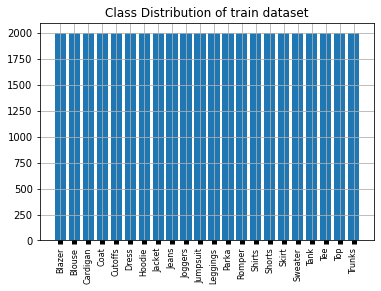

In [9]:
fig, ax = plt.subplots()
plt.bar(list(category_nums.keys()), category_nums.values())
plt.title("Class Distribution of train dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

In [10]:
validation_csv_path = '/home/azure/passion/AI/Demo/sampling_dataframe/demovalidation-Copy1.csv'
validation_df = pd.read_csv(validation_csv_path)
validation_df.head()

,Unnamed: 0,filepath,class_name
0,640,/data/Deepfashion/validation/Blazer/Dropped_La...,Blazer
1,641,/data/Deepfashion/validation/Blazer/Dropped_La...,Blazer
2,642,/data/Deepfashion/validation/Blazer/Dropped_La...,Blazer
3,643,/data/Deepfashion/validation/Blazer/Dropped_La...,Blazer
4,644,/data/Deepfashion/validation/Blazer/Dropped_La...,Blazer


In [11]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    x_col='filepath',
    y_col='class_name',
    target_size=(img_row, img_col),
    batch_size=batch_size_validation
)

Found 8801 validated image filenames belonging to 22 classes.


In [12]:
category_nums = {}

print(validation_generator.filenames[0].split('/')[4])

for filename in validation_generator.filenames:
    class_name = filename.split('/')[4]
    if class_name not in category_nums:
        category_nums[class_name] = 0
    else:
        category_nums[class_name] += 1


print(category_nums)       
print(sorted(category_nums.items(), key=lambda x: x[1], reverse=True))
print(sum(category_nums.values()))

Blazer
{'Blazer': 399, 'Blouse': 399, 'Cardigan': 399, 'Coat': 399, 'Cutoffs': 399, 'Dress': 399, 'Hoodie': 399, 'Jacket': 399, 'Jeans': 398, 'Joggers': 400, 'Jumpsuit': 399, 'Leggings': 399, 'Parka': 400, 'Romper': 399, 'Shirts': 399, 'Shorts': 399, 'Skirt': 399, 'Sweater': 399, 'Tank': 399, 'Tee': 399, 'Top': 399, 'Trunks': 399}
[('Joggers', 400), ('Parka', 400), ('Blazer', 399), ('Blouse', 399), ('Cardigan', 399), ('Coat', 399), ('Cutoffs', 399), ('Dress', 399), ('Hoodie', 399), ('Jacket', 399), ('Jumpsuit', 399), ('Leggings', 399), ('Romper', 399), ('Shirts', 399), ('Shorts', 399), ('Skirt', 399), ('Sweater', 399), ('Tank', 399), ('Tee', 399), ('Top', 399), ('Trunks', 399), ('Jeans', 398)]
8779


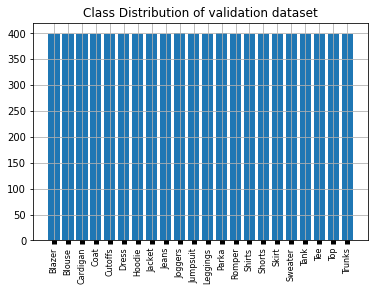

In [13]:
fig, ax = plt.subplots()
plt.bar(list(category_nums.keys()), category_nums.values())
plt.title("Class Distribution of validation dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

In [14]:
class_labels_sampling = list(train_generator.class_indices.keys())
print("class labels sampling keys: ", class_labels_sampling)
print("The number of class labels: ", len(class_labels_sampling))
num_imgs_train_sampling = len(train_generator.filenames)
print("The number of train images sampling: ", num_imgs_train_sampling)
num_imgs_validation_sampling = len(validation_generator.filenames)
print("The number of validation images sampling: ", num_imgs_validation_sampling)

class labels sampling keys:  ['Blazer', 'Blouse', 'Cardigan', 'Coat', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit', 'Leggings', 'Parka', 'Romper', 'Shirts', 'Shorts', 'Skirt', 'Sweater', 'Tank', 'Tee', 'Top', 'Trunks']
The number of class labels:  22
The number of train images sampling:  44000
The number of validation images sampling:  8801


In [19]:
Initialize tne VGG model
vgg_conv = VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(img_row, img_col, img_channel),
    pooling='avg'
)

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

In [125]:
# VGG16
def build_model(vgg_conv, category_nums, drop_rate, learning_rate, momentum_num):
    
    # Create the model
    model = tf.keras.models.Sequential()

    # Add the vgg convolutional base model
    model.add(vgg_conv)

    # Add new layers - Dense, BatchNorm, Activation
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dropout(drop_rate))
    model.add(Activation('tanh'))
    model.add(Dense(512))
    model.add(Dropout(drop_rate))
    model.add(Activation('tanh'))
    model.add(Dense(22))
    model.add(Activation('softmax'))

    # Compile the model with a SGD and a very slow learning rate
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return model

In [126]:
model = build_model(vgg_conv, category_nums, drop_rate, learning_rate, momentum_num)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

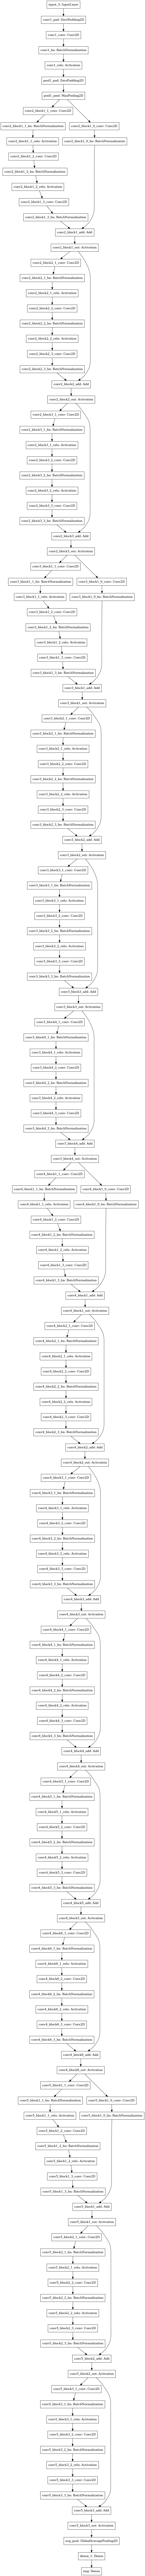

In [24]:
# Show a summary of the model
plot_model(model, to_file='/home/azure/passion/AI/Demo/output/model_summary/vgg16_small_model.jpg')

In [129]:
def curves(model_histories, epochs):

    acc = model_histories.history['accuracy']
    val_acc = model_histories.history['val_accuracy']
    loss = model_histories.history['loss']
    val_loss = model_histories.history['val_loss']

    # Plot
    plt.plot(range(epochs), acc, 'mo', label='Training accuracy')
    plt.plot(range(epochs), val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/Demo/output/plot/small_model_accuracy.jpg')

    plt.figure()
    plt.plot(range(epochs), loss, 'mo', label='Training loss')
    plt.plot(range(epochs), val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/Demo/output/plot/small_model_loss.jpg')
    plt.show()

In [130]:
def callback():
    
    # CSVLogger
    filename = '/home/azure/passion/AI/Demo/output/csv_logger/small_model.csv'
    csv_log = tf.keras.callbacks.CSVLogger(filename, separator=' ', append=False)
    
    # EarlyStopping
#     early_stopping = tf.keras.callbacks.EarlyStopping(
#         monitor='loss', patience=500, verbose=1, mode='min'
#     )
    
    # ModelCheckpoint
    check_point = tf.keras.callbacks.ModelCheckpoint(
        filepath='/home/azure/passion/AI/Demo/output/checkpoint/small_model.ckpt',
        save_best_only=True, save_weights_only=True, monitor='val_loss'
    )
    
    callback_list = [csv_log, check_point]
    return callback_list

In [131]:
callback_list = callback()

In [132]:
def fit_model(model, train_generator, validation_generator, batch_size_train, batch_size_validation, epochs):
    
    history = model.fit(
        train_generator,
        epochs=epochs,
        steps_per_epoch=num_imgs_train_sampling//batch_size_train,
        validation_data=validation_generator,
        validation_steps=num_imgs_validation_sampling//batch_size_validation,
        workers=0,
        verbose=1,
        callbacks=callback_list
    )

    score = model.evaluate(
        validation_generator,
        verbose=1
    )

    return model, history, score

In [133]:
model, history, score = fit_model(model, train_generator, validation_generator, batch_size_train, batch_size_validation, epochs)

# Learning curves
curves(history, epochs)
print('Validation Accuracy:{} \nValidation Loss:{}'.format(score[1] ,score[0]))

# Model Save
model.save('/home/azure/passion/AI/Demo/output/small_model.h5')

Epoch 1/10
687/687 [==============================] - 774s 1s/step - loss: 3.2978 - accuracy: 0.0494 - val_loss: 3.1862 - val_accuracy: 0.0451
Epoch 2/10
136/687 [====>.........................] - ETA: 8:50 - loss: 3.2432 - accuracy: 0.0463

KeyboardInterrupt: 